<a class="anchor" id="0"></a>
# **Ion Switching - Extensive Analysis - EDA + FE + Models**


### **Introduction**


- Welcome to the [University of Liverpool - Ion Switching Competition](https://www.kaggle.com/c/liverpool-ion-switching/submissions)

- In this notebook, we will explore the data, gain insights and make some predictions.

- So, let's dive in.

### **Acknowledgements**

This kernel is based on excellent notebooks written by great kaggle members. These are listed below-

- [EDA - Ion Switching](https://www.kaggle.com/pestipeti/eda-ion-switching)
- [Physically Possible](https://www.kaggle.com/jazivxt/physically-possible)
- [Ion Switching Comp - Signal EDA](https://www.kaggle.com/tarunpaparaju/ion-switching-competition-signal-eda)
- [Simple EDA-Model](https://www.kaggle.com/siavrez/simple-eda-model)
- [One Feature Model](https://www.kaggle.com/cdeotte/one-feature-model-0-930)
- [EDA and model. F1 optimization](https://www.kaggle.com/artgor/eda-and-model-f1-optimization)
- [3 Simple Ideas](https://www.kaggle.com/adrianoavelar/3-simple-ideas-lb-0-938)

**I hope you find this kernel useful and your <font color="red"><b>UPVOTES</b></font> would be very much appreciated**



<a class="anchor" id="0.1"></a>
# **Table of Contents**

- 1. [Load libraries](#1)
- 2. [Read dataset](#2)
- 3. [EDA](#3)
- 4. [Feature Engineering](#4)
- 5. [Modelling](#5)
- 6. [Submission](#6)

# **1. Load libraries** <a class="anchor" id="1"></a>

[Table of Contents](#0.1)


In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# for data processing
import numpy as np 
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# import models
import xgboost as xgb
import lightgbm as lgb

# import metrices and helper 
from sklearn.metrics import f1_score, cohen_kappa_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# **2. Read dataset** <a class="anchor" id="2"></a>

[Table of Contents](#0.1)



In [2]:
%%time

train = pd.read_csv('data/train.csv')

test = pd.read_csv('data/test.csv')


CPU times: user 1.71 s, sys: 242 ms, total: 1.96 s
Wall time: 2.25 s


# **3. EDA** <a class="anchor" id="3"></a>

[Table of Contents](#0.1)

### **Check the shape**

- It is always a good idea to first check the shape of the dataset.

In [3]:
# shape of training set

print('The shape of the training set : {}'.format(train.shape))

The shape of the training set : (5000000, 3)


In [4]:
# shape of test set

print('The shape of the test set : {}'.format(test.shape))

The shape of the test set : (2000000, 2)


### **Check the memory usage**

In [5]:
train.memory_usage(index = True) 

Index                 128
time             40000000
signal           40000000
open_channels    40000000
dtype: int64

In [6]:
test.memory_usage(index = True) 

Index          128
time      16000000
signal    16000000
dtype: int64

### **Reduce memory usage** (optional step)

Taken from [EDA and model F1.optimization](https://www.kaggle.com/artgor/eda-and-model-f1-optimization)

In [7]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


### **Preview dataset**

In [8]:
train.head()

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0


In [9]:
test.head()

,time,signal
0,500.0001,-2.6498
1,500.0002,-2.8494
2,500.0003,-2.8600
3,500.0004,-2.4350
4,500.0005,-2.6155


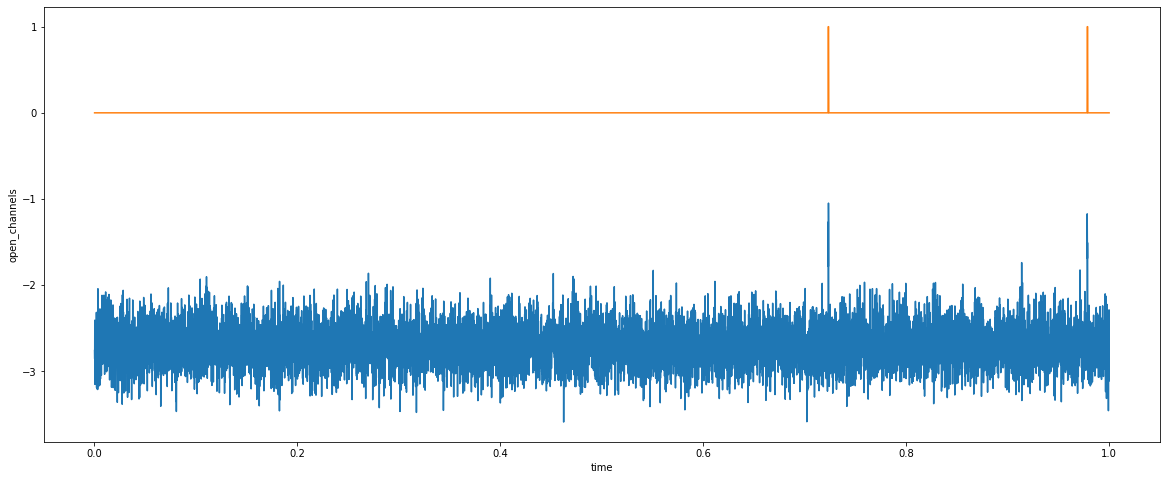

In [10]:
plt.figure(figsize=(20,8))
sns.lineplot(train.time[:10000], train.signal[:10000])
sns.lineplot(train.time[:10000], train.open_channels[:10000])
plt.show()

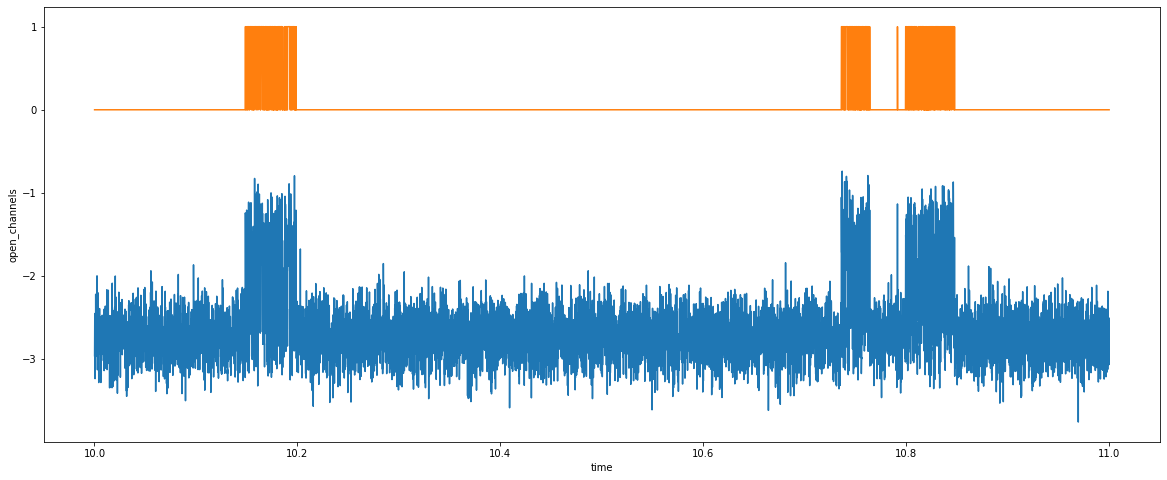

In [19]:
plt.figure(figsize=(20,8))
sns.lineplot(train.time[100000:110000], train.signal[100000:110000])
sns.lineplot(train.time[100000:110000], train.open_channels[100000:110000])
plt.show()

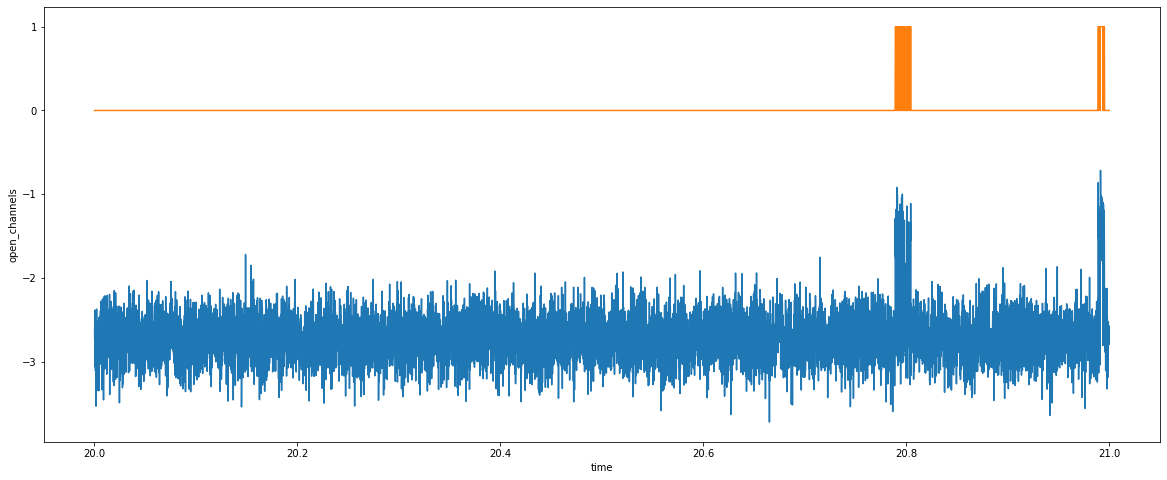

In [20]:
plt.figure(figsize=(20,8))
sns.lineplot(train.time[200000:210000], train.signal[200000:210000])
sns.lineplot(train.time[200000:210000], train.open_channels[200000:210000])
plt.show()

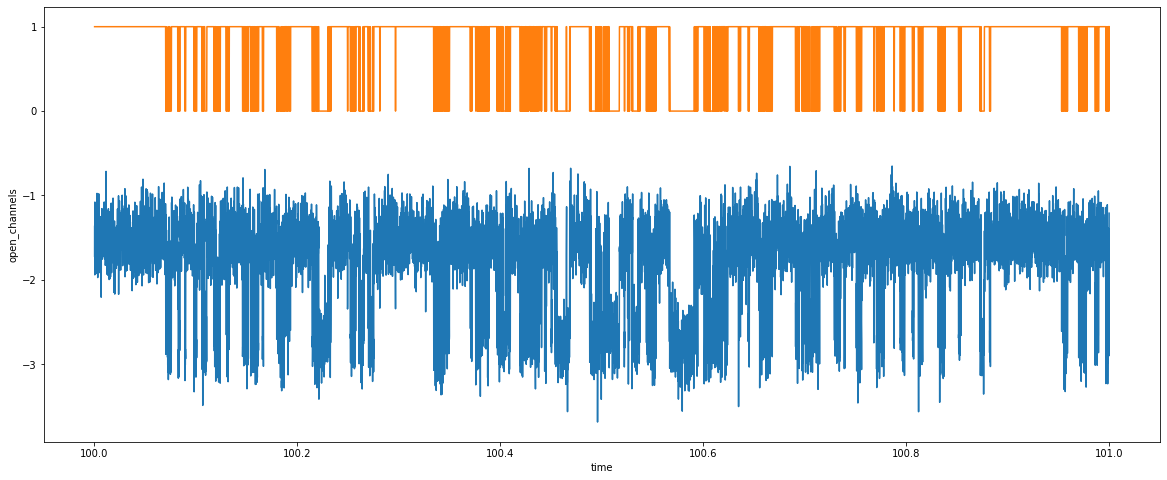

In [21]:
plt.figure(figsize=(20,8))
sns.lineplot(train.time[1000000:1010000], train.signal[1000000:1010000])
sns.lineplot(train.time[1000000:1010000], train.open_channels[1000000:1010000])
plt.show()

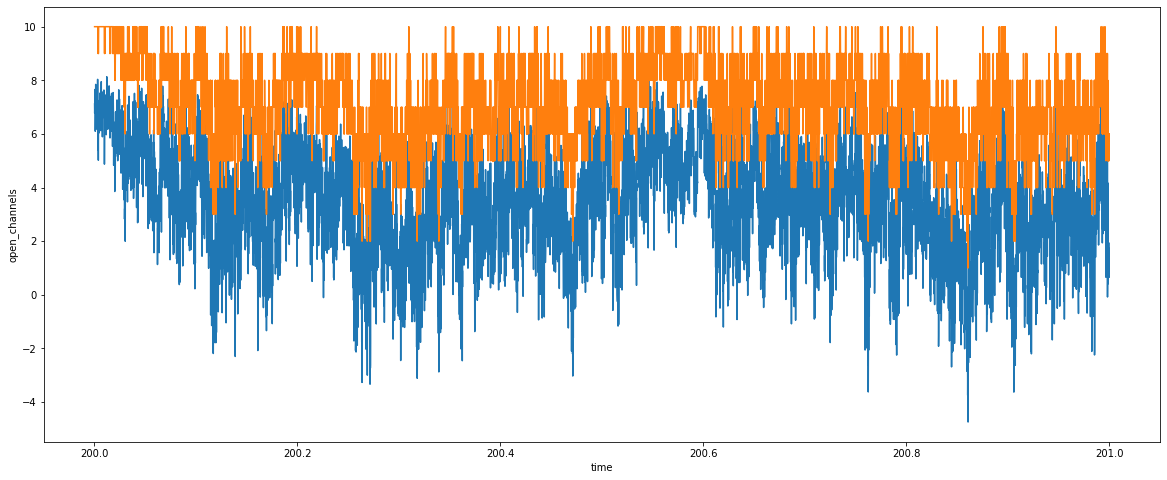

In [22]:
plt.figure(figsize=(20,8))
sns.lineplot(train.time[2000000:2010000], train.signal[2000000:2010000])
sns.lineplot(train.time[2000000:2010000], train.open_channels[2000000:2010000])
plt.show()

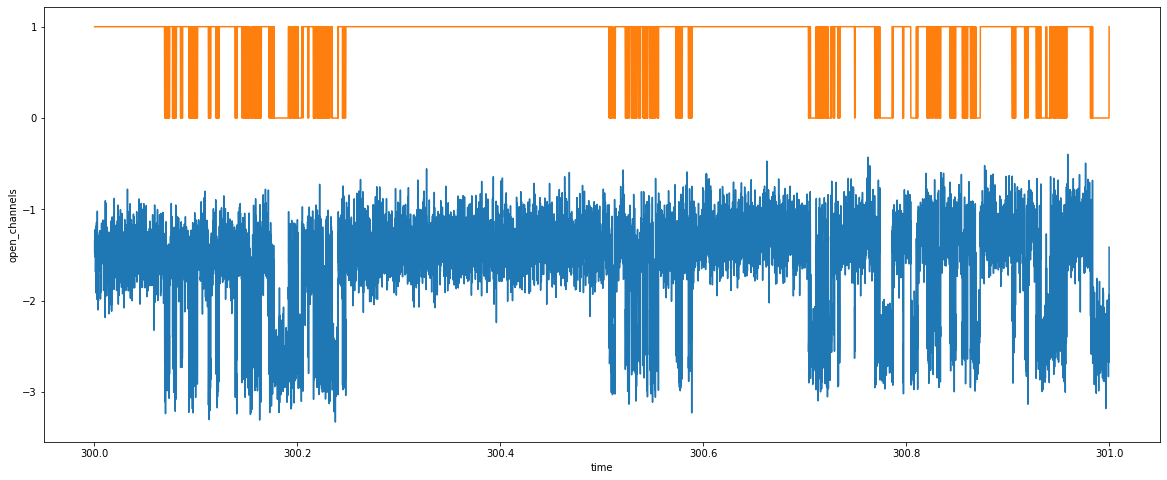

In [23]:
plt.figure(figsize=(20,8))
sns.lineplot(train.time[3000000:3010000], train.signal[3000000:3010000])
sns.lineplot(train.time[3000000:3010000], train.open_channels[3000000:3010000])
plt.show()

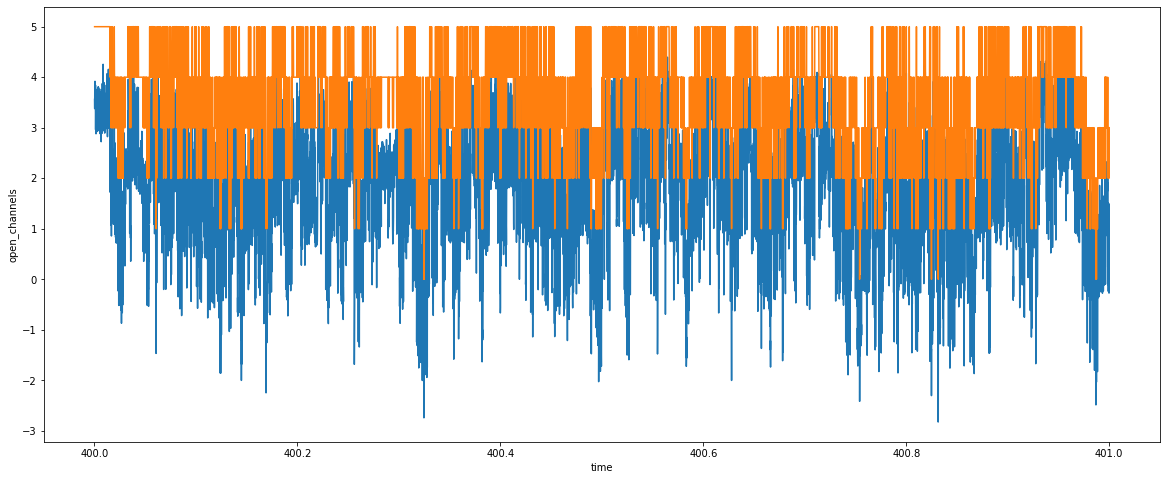

In [24]:
plt.figure(figsize=(20,8))
sns.lineplot(train.time[4000000:4010000], train.signal[4000000:4010000])
sns.lineplot(train.time[4000000:4010000], train.open_channels[4000000:4010000])
plt.show()

# **4. Feature Engineering** <a class="anchor" id="4"></a>

[Table of Contents](#0.1)



In [ ]:
def features(df):
    df = df.sort_values(by=['time']).reset_index(drop=True)
    df.index = ((df.time * 10_000) - 1).values
    df['batch'] = df.index // 50_000
    df['batch_index'] = df.index  - (df.batch * 50_000)
    df['batch_slices'] = df['batch_index']  // 5_000
    df['batch_slices2'] = df.apply(lambda r: '_'.join([str(r['batch']).zfill(3), str(r['batch_slices']).zfill(3)]), axis=1)
    
    for c in ['batch','batch_slices2']:
        d = {}
        d['mean'+c] = df.groupby([c])['signal'].mean()
        d['median'+c] = df.groupby([c])['signal'].median()
        d['max'+c] = df.groupby([c])['signal'].max()
        d['min'+c] = df.groupby([c])['signal'].min()
        d['std'+c] = df.groupby([c])['signal'].std()
        d['mean_abs_chg'+c] = df.groupby([c])['signal'].apply(lambda x: np.mean(np.abs(np.diff(x))))
        d['abs_max'+c] = df.groupby([c])['signal'].apply(lambda x: np.max(np.abs(x)))
        d['abs_min'+c] = df.groupby([c])['signal'].apply(lambda x: np.min(np.abs(x)))
        for v in d:
            df[v] = df[c].map(d[v].to_dict())
        df['range'+c] = df['max'+c] - df['min'+c]
        df['maxtomin'+c] = df['max'+c] / df['min'+c]
        df['abs_avg'+c] = (df['abs_min'+c] + df['abs_max'+c]) / 2
    
    #add shifts
    df['signal_shift_+1'] = [0,] + list(df['signal'].values[:-1])
    df['signal_shift_-1'] = list(df['signal'].values[1:]) + [0]
    for i in df[df['batch_index']==0].index:
        df['signal_shift_+1'][i] = np.nan
    for i in df[df['batch_index']==49999].index:
        df['signal_shift_-1'][i] = np.nan

    for c in [c1 for c1 in df.columns if c1 not in ['time', 'signal', 'open_channels', 'batch', 'batch_index', 'batch_slices', 'batch_slices2']]:
        df[c+'_msignal'] = df[c] - df['signal']
        
    return df

train = features(train)
test = features(test)

# **5. Modeling** <a class="anchor" id="5"></a>

[Table of Contents](#0.1)


In [ ]:
col = [c for c in train.columns if c not in ['time', 'open_channels', 'batch', 'batch_index', 'batch_slices', 'batch_slices2']]
x1, x2, y1, y2 = train_test_split(train[col], train['open_channels'], test_size=0.3, random_state=0)
del train

## **LightGBM Model**

In [ ]:
def lgb_metric(preds, dtrain):
    labels = dtrain.get_label()
    preds = np.round(np.clip(preds, 0, 10)).astype(int)
    score = cohen_kappa_score(labels, preds, weights = 'quadratic')
    return ('KaggleMetric', score, True)

params = {'learning_rate': 0.8, 'max_depth': 7, 'num_leaves':2**7+1, 'metric': 'rmse', 'random_state': 7, 'n_jobs':-1} 
model = lgb.train(params, lgb.Dataset(x1, y1), 2000,  lgb.Dataset(x2, y2), verbose_eval=50, early_stopping_rounds=50, feval=lgb_metric)
preds_lgb = model.predict(test[col], num_iteration=model.best_iteration)
test['open_channels'] = np.round(np.clip(preds_lgb, 0, 10)).astype(int)

test[['time','open_channels']].to_csv('submission_lgbm.csv', index=False, float_format='%.4f')

In [ ]:
lgb.plot_importance(model,importance_type='split', max_num_features=20)

## **CatBoost model**

In [ ]:
from catboost import Pool,CatBoostRegressor

# Initialize CatBoostRegressor
model = CatBoostRegressor(task_type = "CPU",
                          iterations=1000,
                          learning_rate=0.1,
                          random_seed = 42,
                          depth=2,
                         )
# Fit model
model.fit(x1, y1)
# Get predictions
preds_catb = model.predict(test[col])
test['open_channels'] = np.round(np.clip(preds_catb, 0, 10)).astype(int)
test[['time','open_channels']].to_csv('submission_catb.csv', index=False, float_format='%.4f')

# **6. Submission** <a class="anchor" id="6"></a>

[Table of Contents](#0.1)



## **Ensemble predictions**

In [ ]:
preds_comb = 0.5 * preds_lgb + 0.5 * preds_catb
test['open_channels'] = np.round(np.clip(preds_comb, 0, 10)).astype(int)
test[['time','open_channels']].to_csv('submission_comb.csv', index=False, float_format='%.4f')

[Go to Top](#0)